In [0]:
#create sparksession object
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Regresión_lineal').getOrCreate()
import warnings
warnings.filterwarnings("ignore")

In [0]:
#import Linear Regression from spark's MLlib
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F

In [0]:
# Cargamos los datos
#filename = "/FileStore/tables/Linear_regression_dataset.csv"
filename = "/FileStore/tables/housing.csv"
df = spark.read.csv(filename, header=True, inferSchema=True, sep=',')
#display(df)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [0]:
# Tamaño de mis datos 
print((df.count(), len(df.columns)))

(506, 14)


In [0]:
#explore the data
df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [0]:
#view statistical measures of data 
df.describe().show(5,False)

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|crim              |zn                |indus             |chas              |nox                |rm                |age               |dis              |rad              |tax               |ptratio           |b                 |lstat             |medv              |
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|count  |506               |506               |506               |506               |506                |506               |506               |506              |506           

In [0]:
#df.summary().display()
df.summary().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [0]:
from pyspark.sql.types import * 
from pyspark.sql.functions import * 

In [0]:
for colu in df.columns:
    miss = df.filter(col(colu).isNull()).count()
    print(f"{colu} columna {miss} tiene missing value.")

crim columna 0 tiene missing value.
zn columna 0 tiene missing value.
indus columna 0 tiene missing value.
chas columna 0 tiene missing value.
nox columna 0 tiene missing value.
rm columna 0 tiene missing value.
age columna 0 tiene missing value.
dis columna 0 tiene missing value.
rad columna 0 tiene missing value.
tax columna 0 tiene missing value.
ptratio columna 0 tiene missing value.
b columna 0 tiene missing value.
lstat columna 0 tiene missing value.
medv columna 0 tiene missing value.


In [0]:
# estimamo la media
mean_bedroom = df.select(mean(df['age'])).collect()[0][0]
mean_bedroom

Out[11]: 68.57490118577078

In [0]:
df = df.na.fill({'age': mean_bedroom})
#la función de control tiene algún valor faltante
df.filter(col("age").isNull()).count()

Out[13]: 0

In [0]:
#import corr function from pyspark functions
from pyspark.sql.functions import corr

In [0]:
# check for correlation
df.select(corr("age",  "rm")).show()

+--------------------+
|       corr(age, rm)|
+--------------------+
|-0.24026493104775062|
+--------------------+



In [0]:
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler

# StringIndexer ile 'ocean_proximity' label to numeric
stringIndexer = StringIndexer(inputCol="age", outputCol="age_index")
stringIndexerModel = stringIndexer.fit(df)  # Ftting Traing
df_transformed = stringIndexerModel.transform(df)
df_transformed.show(5)
#display(df_transformed)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+---------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|age_index|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+---------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     40.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|    275.0|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|    216.0|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     31.0|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|    195.0|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+---------+
only showing top 5 rows



In [0]:
df1 = df_transformed.drop("age")
df1.show()
#display(df1)

+-------+----+-----+----+-----+-----+------+---+---+-------+------+-----+----+---------+
|   crim|  zn|indus|chas|  nox|   rm|   dis|rad|tax|ptratio|     b|lstat|medv|age_index|
+-------+----+-----+----+-----+-----+------+---+---+-------+------+-----+----+---------+
|0.00632|18.0| 2.31|   0|0.538|6.575|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     40.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|    275.0|
|0.02729| 0.0| 7.07|   0|0.469|7.185|4.9671|  2|242|   17.8|392.83| 4.03|34.7|    216.0|
|0.03237| 0.0| 2.18|   0|0.458|6.998|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     31.0|
|0.06905| 0.0| 2.18|   0|0.458|7.147|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|    195.0|
|0.02985| 0.0| 2.18|   0|0.458| 6.43|6.0622|  3|222|   18.7|394.12| 5.21|28.7|     36.0|
|0.08829|12.5| 7.87|   0|0.524|6.012|5.5605|  5|311|   15.2| 395.6|12.43|22.9|    233.0|
|0.14455|12.5| 7.87|   0|0.524|6.172|5.9505|  5|311|   15.2| 396.9|19.15|27.1|     78.0|
|0.21124|12.5| 7.87| 

In [0]:
#import vectorassembler to create dense vectors
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [0]:
#select the columns to create input vector
df1.columns

Out[25]: ['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv',
 'age_index']

In [0]:
# Creamos el vector assembler             Variables independientes                         Vector 
vec_assmebler = VectorAssembler(inputCols=["indus", "chas", "nox", "rm",  "age_index"],
    outputCol="features")

In [0]:
#transform the values
features_df = vec_assmebler.transform(df1)

In [0]:
#validate the presence of dense vectors 
features_df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)
 |-- age_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [0]:
#features_df.display()
features_df.show(5)

+-------+----+-----+----+-----+-----+------+---+---+-------+------+-----+----+---------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm|   dis|rad|tax|ptratio|     b|lstat|medv|age_index|            features|
+-------+----+-----+----+-----+-----+------+---+---+-------+------+-----+----+---------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|     40.0|[2.31,0.0,0.538,6...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|    275.0|[7.07,0.0,0.469,6...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|4.9671|  2|242|   17.8|392.83| 4.03|34.7|    216.0|[7.07,0.0,0.469,7...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|6.0622|  3|222|   18.7|394.63| 2.94|33.4|     31.0|[2.18,0.0,0.458,6...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|    195.0|[2.18,0.0,0.458,7...|
+-------+----+-----+----+-----+-----+------+---+---+-------+------+-----+----+---------+--------------------+
only showi

In [0]:
#view the details of dense vector
features_df.select('features').show(5,False)

+----------------------------+
|features                    |
+----------------------------+
|[2.31,0.0,0.538,6.575,40.0] |
|[7.07,0.0,0.469,6.421,275.0]|
|[7.07,0.0,0.469,7.185,216.0]|
|[2.18,0.0,0.458,6.998,31.0] |
|[2.18,0.0,0.458,7.147,195.0]|
+----------------------------+
only showing top 5 rows



In [0]:
# Creamos una nueva tabla con el vector y la variable de salidad
model_df = features_df.select('features',"medv")
model_df.show(5,False)

+----------------------------+----+
|features                    |medv|
+----------------------------+----+
|[2.31,0.0,0.538,6.575,40.0] |24.0|
|[7.07,0.0,0.469,6.421,275.0]|21.6|
|[7.07,0.0,0.469,7.185,216.0]|34.7|
|[2.18,0.0,0.458,6.998,31.0] |33.4|
|[2.18,0.0,0.458,7.147,195.0]|36.2|
+----------------------------+----+
only showing top 5 rows



In [0]:
#size of model df
print((model_df.count(), len(model_df.columns)))

(506, 2)


In [0]:
# Dividir los datos en entrenamiento y en datos de prueba
train_df,test_df = model_df.randomSplit([0.7,0.3])

In [0]:
train_df.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.46,0.0,0.422,7...|50.0|
|[0.74,0.0,0.41,6....|24.7|
|[1.21,1.0,0.401,7...|50.0|
|[1.22,0.0,0.403,7...|35.4|
|[1.25,0.0,0.429,6...|22.9|
|[1.25,0.0,0.429,6...|26.6|
|[1.38,0.0,0.4161,...|33.0|
|[1.47,0.0,0.403,6...|34.9|
|[1.52,0.0,0.404,7...|34.6|
|[1.52,0.0,0.404,7...|33.3|
|[1.69,0.0,0.411,6...|24.1|
|[1.76,0.0,0.385,6...|20.1|
|[1.89,0.0,0.518,6...|16.5|
|[1.91,0.0,0.413,5...|18.2|
|[2.01,0.0,0.435,6...|24.5|
|[2.02,0.0,0.41,6....|30.1|
|[2.18,0.0,0.458,7...|36.2|
|[2.18,0.0,0.472,6...|28.4|
|[2.24,0.0,0.4,6.3...|22.5|
|[2.24,0.0,0.4,6.8...|24.8|
+--------------------+----+
only showing top 20 rows



In [0]:
print((train_df.count(), len(train_df.columns)))

(361, 2)


In [0]:
print((test_df.count(), len(test_df.columns)))

(145, 2)


In [0]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               361|
|   mean|22.220498614958455|
| stddev| 9.000856179992809|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
# construyo Linear Regression model 
lin_Reg = LinearRegression(labelCol = 'medv') # labelcol= la variable objetivo o Target 

In [0]:
# Se entrena el modelo
lr_model = lin_Reg.fit(train_df) # utliza los datos de entrenamiento

In [0]:
pred = lr_model.transform(test_df)
pred.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[1.32,0.0,0.411,6...|31.6|29.770043126849234|
|[1.47,0.0,0.403,7...|32.9|31.984142513401824|
|[1.52,0.0,0.404,7...|30.3|31.665702170650075|
|[1.52,0.0,0.442,7...|32.7|32.362092606840605|
|[1.69,0.0,0.411,5...|18.6|22.983585579535696|
|[1.91,0.0,0.413,5...|20.6|23.374654025385592|
|[2.03,0.0,0.415,6...|24.1|24.972584051472626|
|[2.03,0.0,0.415,7...|42.3| 35.05271766977454|
|[2.18,0.0,0.458,6...|28.7| 26.15105747167559|
|[2.18,0.0,0.458,6...|33.4|30.128002833385654|
|[2.18,0.0,0.472,6...|28.2|29.189965160169177|
|[2.18,0.0,0.472,7...|36.1| 31.62454898058085|
|[2.18,0.0,0.472,7...|33.4|33.200827280915576|
|[2.46,0.0,0.488,7...|39.8|  35.4111119704708|
|[2.46,0.0,0.488,7...|50.0| 35.54687495118091|
|[2.89,0.0,0.445,6...|28.4|27.740955304192635|
|[2.89,0.0,0.445,7...|33.2| 33.31141860322168|
|[2.89,0.0,0.445,8...|38.7|37.950145565540495|
|[2.93,0.0,0.

In [0]:
print("La intercepción del Modelo es:",lr_model.intercept)

La intercepción del Modelo es: -12.920386726022148


In [0]:
print("Los coeficiente del modelos son:", lr_model.coefficients)

Los coeficiente del modelos son: [-0.2136945250149451,3.9570318875043933,-12.232869845717603,7.013000423578981,0.001287775776559422]


In [0]:
# predición del modelo 
training_predictions = lr_model.evaluate(train_df)
training_predictions

Out[48]: <pyspark.ml.regression.LinearRegressionSummary at 0x7f5a144d9bb0>

In [0]:
print("El MSE es:", training_predictions.meanSquaredError)

El MSE es: 37.85035485432008


In [0]:
print("El R2 es:",training_predictions.r2)

El R2 es: 0.5315027868820221


Paso 7: evaluar el modelo de regresión lineal en datos de prueba

In [0]:
# Haciendo la prediciones con los datos de prueba
test_results = lr_model.evaluate(test_df)
test_results

Out[52]: <pyspark.ml.regression.LinearRegressionSummary at 0x7f5a143fe400>

In [0]:
#view the residual errors based on predictions 
test_results.residuals.show(10)

+-------------------+
|          residuals|
+-------------------+
|  1.829956873150767|
| 0.9158574865981741|
|-1.3657021706500743|
| 0.3379073931593979|
| -4.383585579535694|
|-2.7746540253855905|
|-0.8725840514726251|
|   7.24728233022546|
| 2.5489425283244103|
| 3.2719971666143444|
+-------------------+
only showing top 10 rows



In [0]:
#coefficient of determination value for model
print("El R2 para el conjunto de Prueba es.",test_results.r2)

El R2 para el conjunto de Prueba es. 0.6247475157325926


In [0]:
print("EL RMSE para el Test es:",test_results.rootMeanSquaredError)

EL RMSE para el Test es: 5.894967613075959


In [0]:
print("EL MSE para el Test es:",test_results.meanSquaredError)

EL MSE para el Test es: 34.750643159214476


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
# Performans Metric
evaluator = RegressionEvaluator(labelCol = "medv", predictionCol="prediction")
lrRmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
lrMae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
lrR2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print(f"Linear Regression - RMSE: {lrRmse}")
print(f"Linear Regression - MAE: {lrMae}")
print(f"Linear Regression - R^2: {lrR2}")

Linear Regression - RMSE: 5.894967613075959
Linear Regression - MAE: 4.178767921934842
Linear Regression - R^2: 0.6247475157325926


In [0]:
pred.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[1.32,0.0,0.411,6...|31.6|29.770043126849234|
|[1.47,0.0,0.403,7...|32.9|31.984142513401824|
|[1.52,0.0,0.404,7...|30.3|31.665702170650075|
|[1.52,0.0,0.442,7...|32.7|32.362092606840605|
|[1.69,0.0,0.411,5...|18.6|22.983585579535696|
+--------------------+----+------------------+
only showing top 5 rows



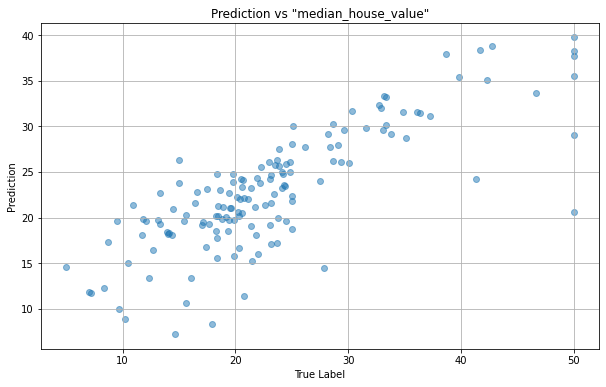

In [0]:
import matplotlib.pyplot as plt

# Pandas DataFrame
resultado = pred.select("prediction", "medv").toPandas()
# Graph for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(resultado["medv"], resultado['prediction'], alpha=0.5)
plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Prediction vs "median_house_value"')
plt.grid(True)
plt.show()